In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_dir = r"F:\Project\GPU\CV\brain2_filtered\Training"
test_dir = r"F:\Project\GPU\CV\brain2_filtered\Testing"

print("Training directory exists:", os.path.exists(train_dir))
print("Testing directory exists:", os.path.exists(test_dir))

Using device: cuda
Training directory exists: True
Testing directory exists: True


In [2]:
# Enhanced transforms with more augmentation for better generalization
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Check class distribution
class_names = train_dataset.classes
class_counts = {class_names[i]: 0 for i in range(len(class_names))}
for _, label in train_dataset:
    class_counts[class_names[label]] += 1

print(f"Classes: {class_names}")
print("Training class distribution:", class_counts)

# Calculate weights for imbalanced classes if needed
class_weights = []
for class_name in class_names:
    weight = len(train_dataset) / (len(class_names) * class_counts[class_name])
    class_weights.append(weight)
    
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights for loss: {class_weights}")

# DataLoaders with optimal settings
batch_size = 64  # Adjusted for hybrid model
num_workers = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, 
    prefetch_factor=2, persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True
)

print(f"Training images: {len(train_dataset)} | Batches: {len(train_loader)}")
print(f"Testing images: {len(test_dataset)} | Batches: {len(test_loader)}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training class distribution: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Class weights for loss: tensor([1.0810, 1.0665, 0.8953, 0.9801], device='cuda:0')
Training images: 5712 | Batches: 90
Testing images: 1311 | Batches: 21


In [3]:
class HybridTransformerCNN(nn.Module):
    def __init__(self, num_classes=4, embed_dim=512, num_heads=8, num_layers=3, dropout=0.1):
        super(HybridTransformerCNN, self).__init__()
        
        # CNN Backbone (using EfficientNet for better feature extraction)
        self.cnn_backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")
        
        # Remove the classification head
        self.cnn_features = nn.Sequential(*list(self.cnn_backbone.children())[:-1])
        
        # Get CNN feature dimensions
        cnn_output_features = self.cnn_backbone.classifier[1].in_features
        
        # Project CNN features to Transformer dimension
        self.cnn_projection = nn.Linear(cnn_output_features, embed_dim)
        
        # Positional encoding for patches
        self.positional_encoding = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Transformer Encoder
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Classification head
        self.classification_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        # Attention pooling
        self.attention_pooling = nn.Sequential(
            nn.Linear(embed_dim, 1),
            nn.Tanh()
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Extract CNN features
        cnn_features = self.cnn_features(x)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)
        
        # Project to transformer dimension
        projected_features = self.cnn_projection(cnn_features)
        projected_features = projected_features.unsqueeze(1)  # Add sequence dimension
        
        # Add positional encoding
        projected_features = projected_features + self.positional_encoding
        
        # Apply transformer
        transformer_features = self.transformer_encoder(projected_features)
        
        # Attention pooling
        attention_weights = self.attention_pooling(transformer_features)
        attention_weights = torch.softmax(attention_weights, dim=1)
        pooled_features = torch.sum(attention_weights * transformer_features, dim=1)
        
        # Classification
        pooled_features = self.dropout(pooled_features)
        output = self.classification_head(pooled_features)
        
        return output, attention_weights

In [4]:
def train_epoch(model, loader, criterion, optimizer, scaler, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Get only logits from hybrid model
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler:
            scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Get only logits
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

def plot_training_curves(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(test_losses, label='Test Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curve
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(test_accs, label='Test Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

Total parameters: 15,535,977
Trainable parameters: 15,535,977

Starting training with Hybrid Transformer-CNN model...

Epoch 1/25
Learning Rate: 1.00e-04


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.9041 | Train Acc: 0.6406


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.6027 | Test Acc:  0.8002
✓ Model saved with accuracy: 0.8002

Epoch 2/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.4230 | Train Acc: 0.8475


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.3093 | Test Acc:  0.8848
✓ Model saved with accuracy: 0.8848

Epoch 3/25
Learning Rate: 1.00e-06


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.3536 | Train Acc: 0.8710


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.2544 | Test Acc:  0.9062
✓ Model saved with accuracy: 0.9062

Epoch 4/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.3088 | Train Acc: 0.8922


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.1739 | Test Acc:  0.9352
✓ Model saved with accuracy: 0.9352

Epoch 5/25
Learning Rate: 1.00e-04


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.2588 | Train Acc: 0.9104


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.2227 | Test Acc:  0.9375
✓ Model saved with accuracy: 0.9375

Epoch 6/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.2238 | Train Acc: 0.9217


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.1265 | Test Acc:  0.9504
✓ Model saved with accuracy: 0.9504

Epoch 7/25
Learning Rate: 1.00e-06


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.2066 | Train Acc: 0.9256


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.1000 | Test Acc:  0.9634
✓ Model saved with accuracy: 0.9634

Epoch 8/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1930 | Train Acc: 0.9356


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.1537 | Test Acc:  0.9466

Epoch 9/25
Learning Rate: 1.00e-04


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1801 | Train Acc: 0.9338


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.1033 | Test Acc:  0.9664
✓ Model saved with accuracy: 0.9664

Epoch 10/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1587 | Train Acc: 0.9424


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0953 | Test Acc:  0.9695
✓ Model saved with accuracy: 0.9695

Epoch 11/25
Learning Rate: 1.00e-06


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1515 | Train Acc: 0.9485


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0723 | Test Acc:  0.9741
✓ Model saved with accuracy: 0.9741

Epoch 12/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1665 | Train Acc: 0.9371


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0653 | Test Acc:  0.9817
✓ Model saved with accuracy: 0.9817

Epoch 13/25
Learning Rate: 1.00e-04


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1419 | Train Acc: 0.9541


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0404 | Test Acc:  0.9817

Epoch 14/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1612 | Train Acc: 0.9477


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0368 | Test Acc:  0.9901
✓ Model saved with accuracy: 0.9901

Epoch 15/25
Learning Rate: 1.00e-06


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1436 | Train Acc: 0.9536


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0643 | Test Acc:  0.9847

Epoch 16/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1255 | Train Acc: 0.9576


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0348 | Test Acc:  0.9878

Epoch 17/25
Learning Rate: 1.00e-04


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1328 | Train Acc: 0.9529


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0800 | Test Acc:  0.9756

Epoch 18/25
Learning Rate: 5.05e-05


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1411 | Train Acc: 0.9545


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0321 | Test Acc:  0.9893

Epoch 19/25
Learning Rate: 1.00e-06


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Train Loss: 0.1221 | Train Acc: 0.9601


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Test Loss:  0.0405 | Test Acc:  0.9855

Early stopping at epoch 19

Training completed!
Best test accuracy: 0.9901


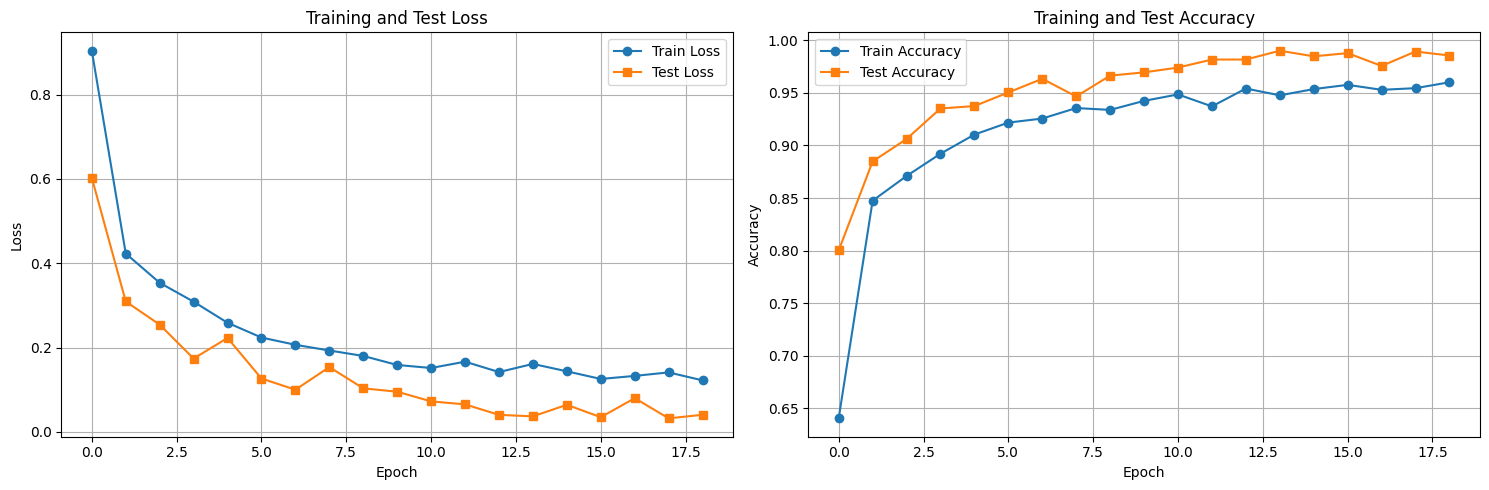


Loading best model for evaluation...


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

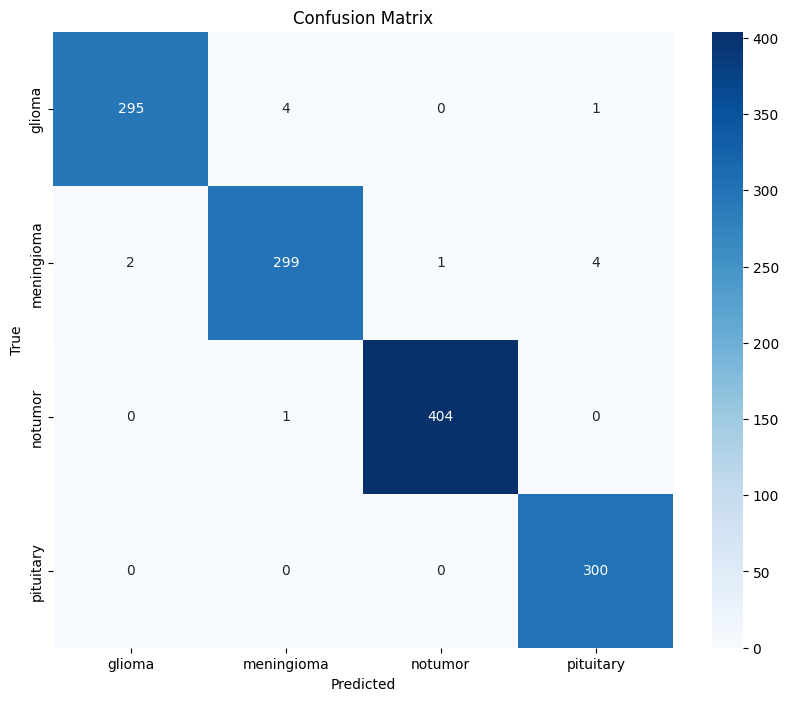


Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.98      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [5]:
# Initialize model
model = HybridTransformerCNN(num_classes=len(class_names))
# Alternative: model = SimpleCNNTransformer(num_classes=len(class_names))
model = model.to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Gradient scaler for mixed precision
scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')

# Training parameters
num_epochs = 25
patience = 5
best_acc = 0
epochs_no_improve = 0

# Lists to store metrics
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print("\nStarting training with Hybrid Transformer-CNN model...")

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Train
    train_loss, train_acc, train_preds, train_labels = train_epoch(
        model, train_loader, criterion, optimizer, scaler, device, scheduler
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    # Evaluate
    test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(
        model, test_loader, criterion, device
    )
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")
    
    # Early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        epochs_no_improve = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names,
        }, 'best_hybrid_model.pth')
        print(f"✓ Model saved with accuracy: {best_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("\nTraining completed!")
print(f"Best test accuracy: {best_acc:.4f}")

# Plot training curves
plot_training_curves(train_losses, train_accs, test_losses, test_accs)

# Plot confusion matrix for best model
print("\nLoading best model for evaluation...")
checkpoint = torch.load('best_hybrid_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(
    model, test_loader, criterion, device
)

plot_confusion_matrix(test_labels, test_preds, class_names)

Using device: cuda
Training directory exists: True
Testing directory exists: True
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training images: 5712
Testing images: 1311
Model initialized. Total parameters: 15,534,952
Starting training...

Epoch 1/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.9346 | Train Acc: 0.6439


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.5785 | Test Acc:  0.8452
✓ Model saved with accuracy: 0.8452

Epoch 2/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4627 | Train Acc: 0.8384


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.3823 | Test Acc:  0.8787
✓ Model saved with accuracy: 0.8787

Epoch 3/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3614 | Train Acc: 0.8762


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.2308 | Test Acc:  0.9130
✓ Model saved with accuracy: 0.9130

Epoch 4/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3017 | Train Acc: 0.8887


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.1537 | Test Acc:  0.9481
✓ Model saved with accuracy: 0.9481

Epoch 5/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.2676 | Train Acc: 0.9083


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.1528 | Test Acc:  0.9489
✓ Model saved with accuracy: 0.9489

Epoch 6/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.2424 | Train Acc: 0.9137


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.1366 | Test Acc:  0.9542
✓ Model saved with accuracy: 0.9542

Epoch 7/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1990 | Train Acc: 0.9328


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0743 | Test Acc:  0.9741
✓ Model saved with accuracy: 0.9741

Epoch 8/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1906 | Train Acc: 0.9342


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0587 | Test Acc:  0.9794
✓ Model saved with accuracy: 0.9794

Epoch 9/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1818 | Train Acc: 0.9373


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0504 | Test Acc:  0.9809
✓ Model saved with accuracy: 0.9809

Epoch 10/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1732 | Train Acc: 0.9380


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0454 | Test Acc:  0.9817
✓ Model saved with accuracy: 0.9817

Epoch 11/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1571 | Train Acc: 0.9475


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0554 | Test Acc:  0.9771

Epoch 12/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1510 | Train Acc: 0.9442


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0565 | Test Acc:  0.9756

Epoch 13/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1463 | Train Acc: 0.9480


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0413 | Test Acc:  0.9840
✓ Model saved with accuracy: 0.9840

Epoch 14/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1413 | Train Acc: 0.9492


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0400 | Test Acc:  0.9847
✓ Model saved with accuracy: 0.9847

Epoch 15/15


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1387 | Train Acc: 0.9494


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Test Loss:  0.0384 | Test Acc:  0.9863
✓ Model saved with accuracy: 0.9863

Training completed!


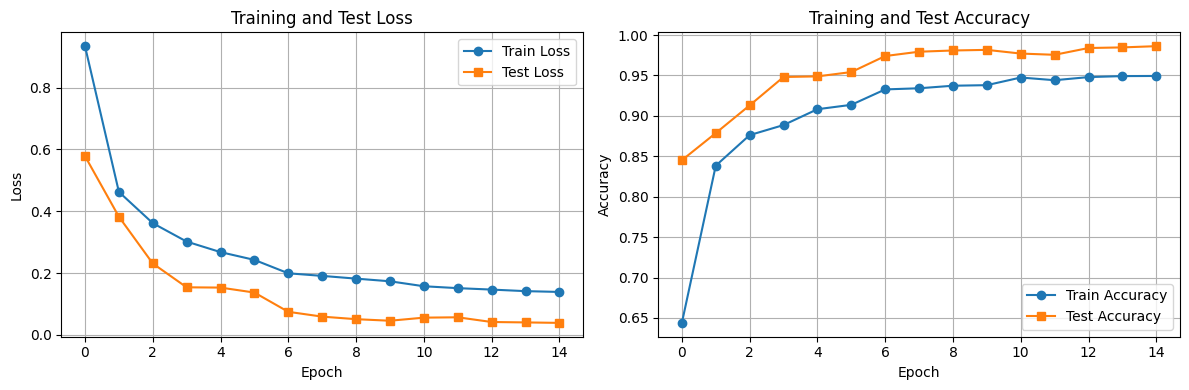


Loading best model...

VISUALIZING PREDICTIONS

1. Visualizing sample predictions...


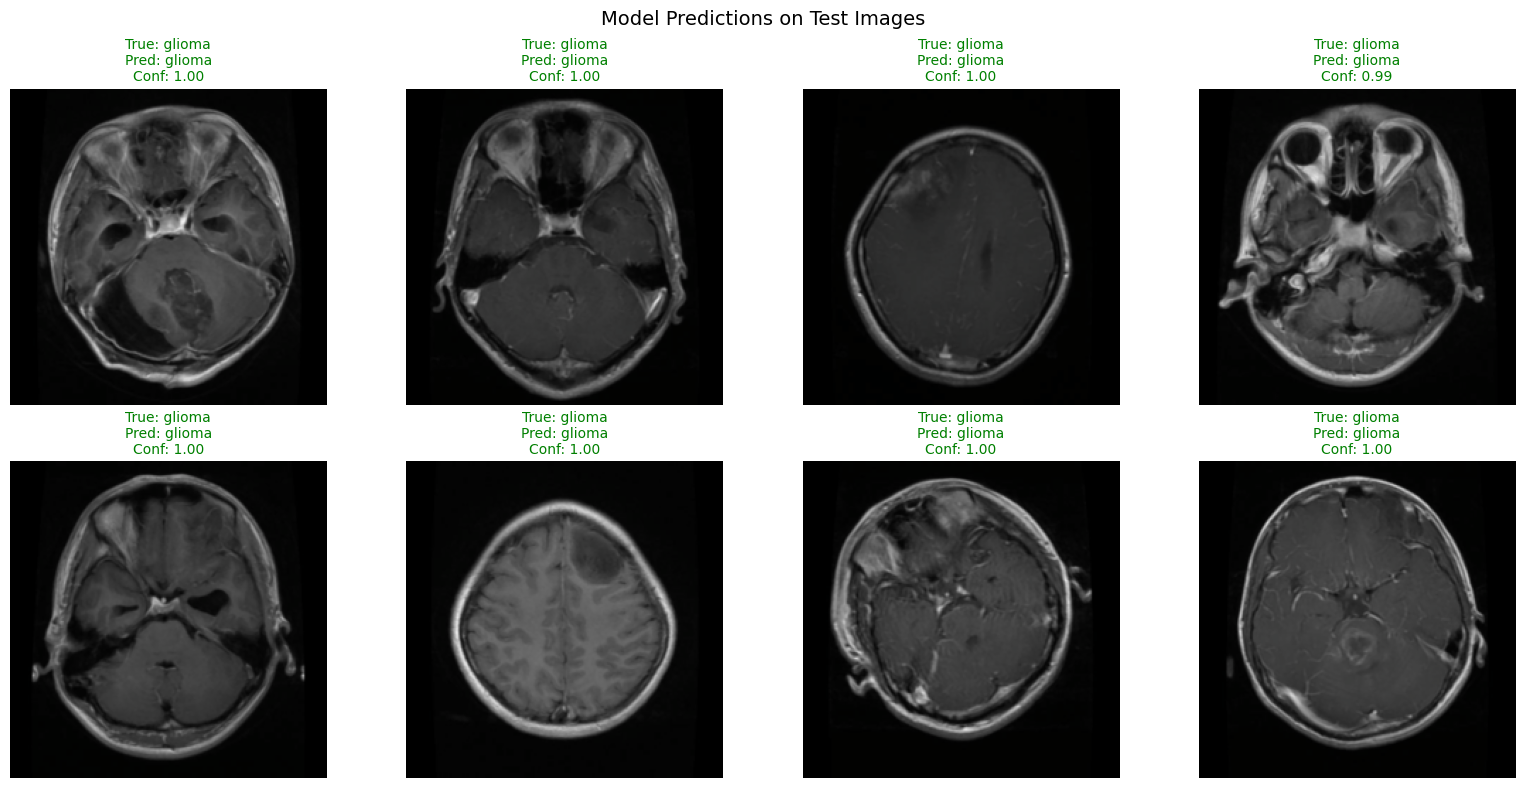


2. Getting all test predictions...


Getting predictions:   0%|          | 0/41 [00:00<?, ?it/s]


3. Creating confusion matrix...


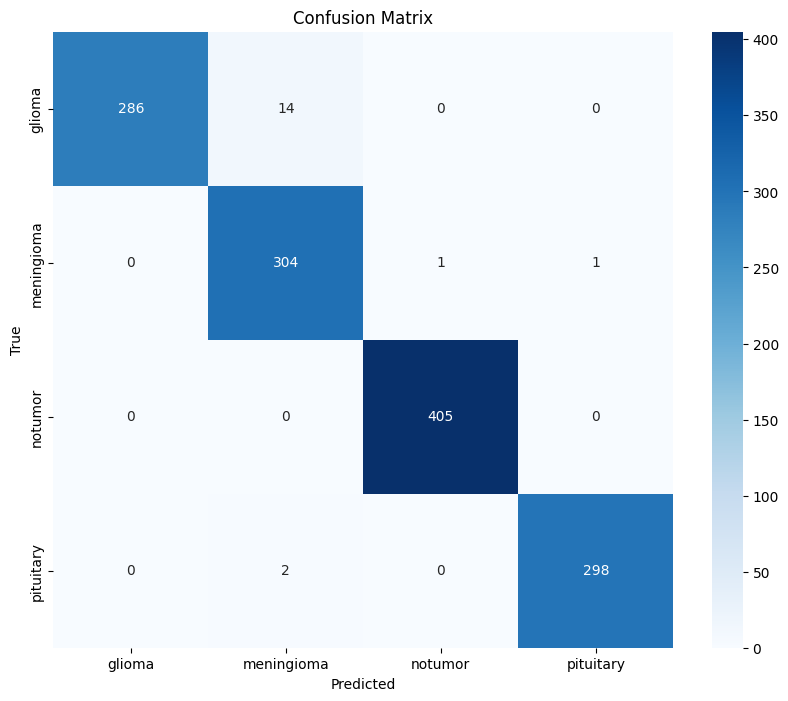


4. Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.98       300
  meningioma       0.95      0.99      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311


5. Creating ROC curves...


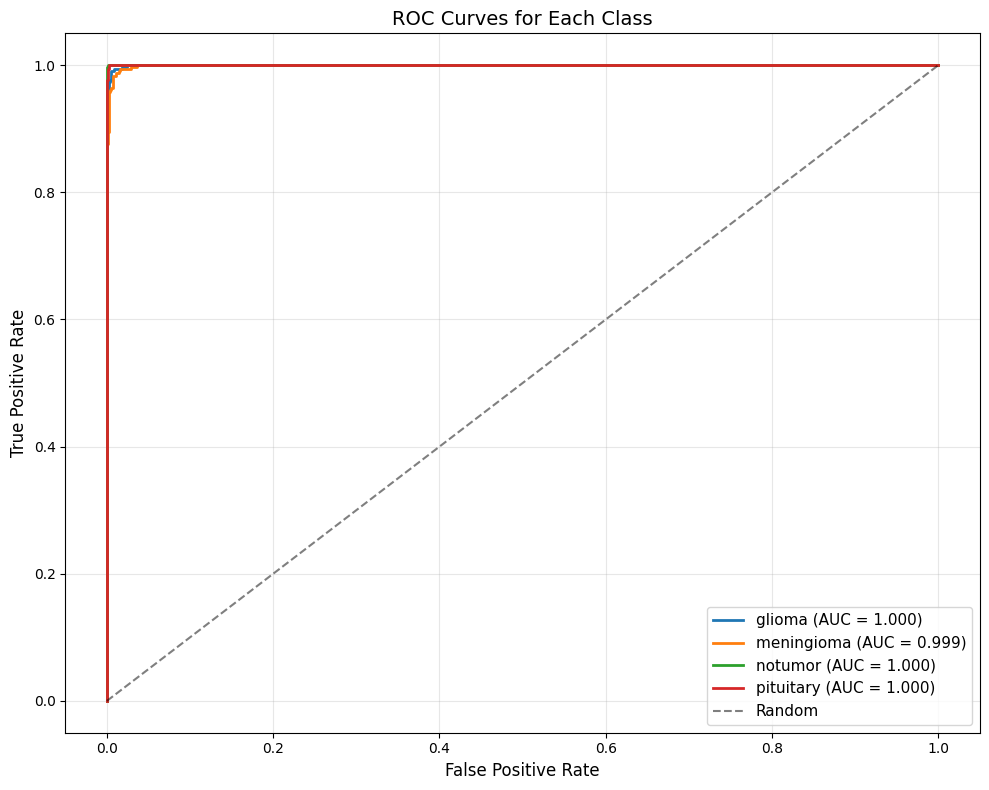


6. Overall Test Accuracy: 0.9863

7. Per-class accuracy:
  glioma: 0.9533 (300 samples)
  meningioma: 0.9935 (306 samples)
  notumor: 1.0000 (405 samples)
  pituitary: 0.9933 (300 samples)

8. Creating probability distribution plots...


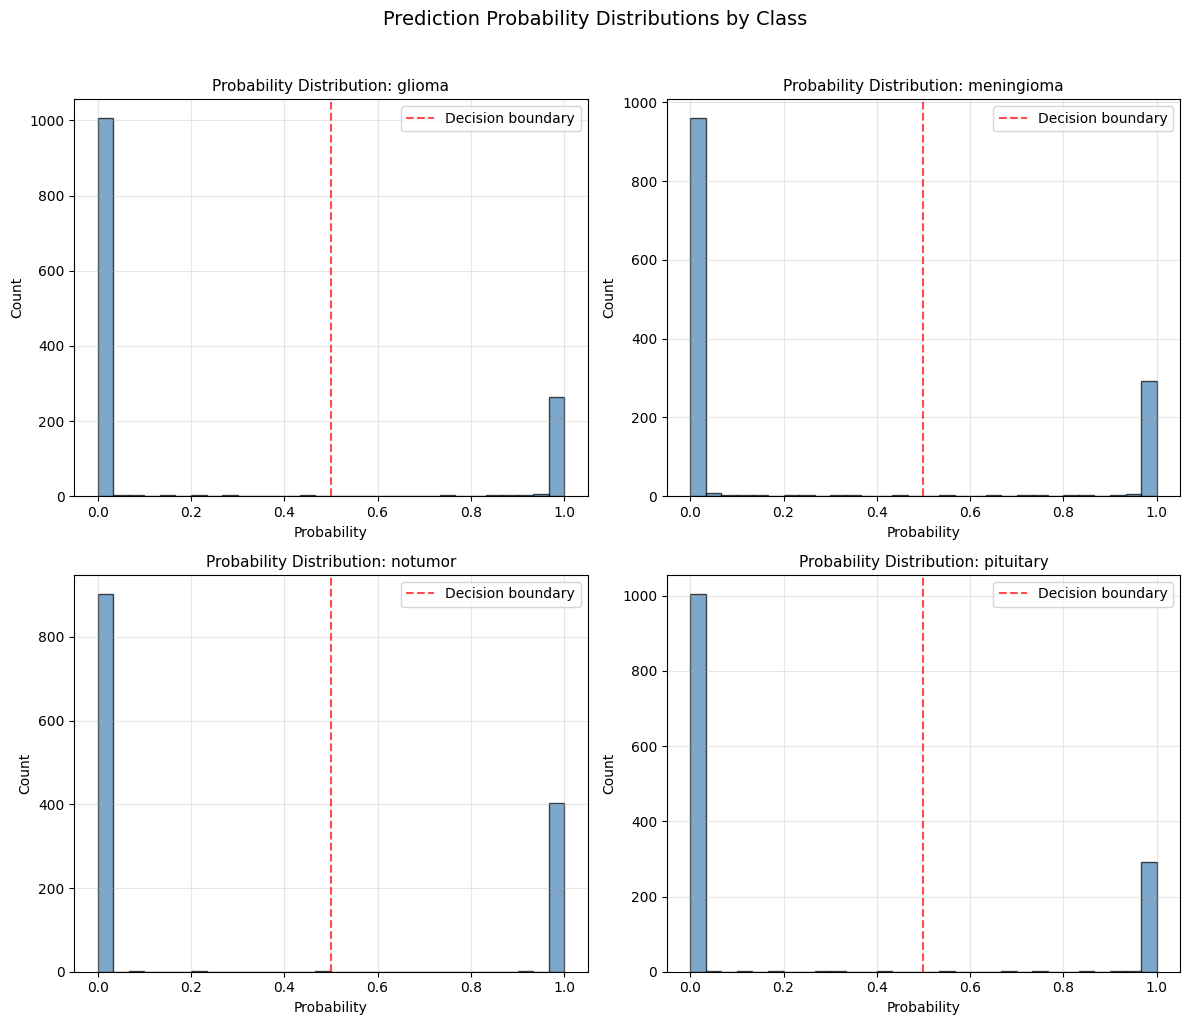


VISUALIZATION COMPLETE


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
train_dir = r"F:\Project\GPU\CV\brain2_filtered\Training"
test_dir = r"F:\Project\GPU\CV\brain2_filtered\Testing"

print("Training directory exists:", os.path.exists(train_dir))
print("Testing directory exists:", os.path.exists(test_dir))

# Data Loading and Preparation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")

# DataLoaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

# Hybrid Transformer-CNN Model
class HybridTransformerCNN(nn.Module):
    def __init__(self, num_classes=4, embed_dim=512, num_heads=8, num_layers=3, dropout=0.3):
        super(HybridTransformerCNN, self).__init__()
        
        # CNN Backbone (EfficientNet)
        self.cnn_backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")
        
        # Remove classification head
        self.cnn_features = nn.Sequential(*list(self.cnn_backbone.children())[:-1])
        
        # Get CNN feature dimensions
        cnn_output_features = self.cnn_backbone.classifier[1].in_features
        
        # Project to transformer dimension
        self.cnn_projection = nn.Linear(cnn_output_features, embed_dim)
        
        # Transformer Encoder
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Extract CNN features
        cnn_features = self.cnn_features(x)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)
        
        # Project to transformer dimension
        projected_features = self.cnn_projection(cnn_features)
        projected_features = projected_features.unsqueeze(1)  # Add sequence dimension
        
        # Apply transformer
        transformer_features = self.transformer_encoder(projected_features)
        transformer_features = transformer_features.squeeze(1)
        
        # Classification
        output = self.classifier(transformer_features)
        
        return output

# Initialize model
model = HybridTransformerCNN(num_classes=len(class_names)).to(device)
print(f"Model initialized. Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training functions
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

# Training loop
def train_model(model, train_loader, test_loader, num_epochs=15, lr=1e-4):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Track metrics
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Evaluate
        test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")
        
        # Update scheduler
        scheduler.step()
        
        # Save best model
        if test_acc == max(test_accs):
            torch.save(model.state_dict(), 'best_hybrid_model.pth')
            print(f"✓ Model saved with accuracy: {test_acc:.4f}")
    
    print("\nTraining completed!")
    return train_losses, train_accs, test_losses, test_accs

# Train the model
train_losses, train_accs, test_losses, test_accs = train_model(
    model, train_loader, test_loader, num_epochs=15
)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(test_accs, label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualization function
def visualize_predictions(model, loader, device, class_names, num_samples=8):
    """Visualize model predictions on test samples"""
    model.eval()
    
    # Get a batch of data
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images, labels = images[:num_samples].to(device), labels[:num_samples]
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
    
    # Convert images back to normal RGB for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    # Create figure for predictions
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for idx in range(num_samples):
        # Convert tensor to numpy image
        img = inv_normalize(images[idx]).cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)  # Clip to valid range
        
        # Display image
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # Get labels and confidence
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        confidence = probs[idx][preds[idx]].item()
        
        # Color code: green for correct, red for wrong
        color = 'green' if true_label == pred_label else 'red'
        axes[idx].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", 
                           color=color, fontsize=10)
    
    plt.suptitle('Model Predictions on Test Images', fontsize=14)
    plt.tight_layout()
    plt.show()

# Get all test predictions for metrics
def get_test_predictions(model, loader, device):
    """Get all predictions from test set"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Getting predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Load best model
print("\nLoading best model...")
model.load_state_dict(torch.load('best_hybrid_model.pth'))

# Now run the visualizations
print("\n" + "="*50)
print("VISUALIZING PREDICTIONS")
print("="*50)

# 1. Visualize sample predictions
print("\n1. Visualizing sample predictions...")
visualize_predictions(model, test_loader, device, class_names)

# 2. Get all test predictions for metrics
print("\n2. Getting all test predictions...")
test_labels, test_preds, test_probs = get_test_predictions(model, test_loader, device)

# 3. Confusion Matrix
print("\n3. Creating confusion matrix...")
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Classification Report
print("\n4. Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# 5. ROC Curves
print("\n5. Creating ROC curves...")
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
    auc = roc_auc_score(test_labels == i, test_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Each Class', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Calculate overall accuracy
accuracy = (test_labels == test_preds).mean()
print(f"\n6. Overall Test Accuracy: {accuracy:.4f}")

# 7. Per-class accuracy
print("\n7. Per-class accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = test_labels == i
    if np.sum(class_mask) > 0:
        class_acc = (test_preds[class_mask] == test_labels[class_mask]).mean()
        print(f"  {class_name}: {class_acc:.4f} ({np.sum(class_mask)} samples)")

# 8. Additional visualizations
print("\n8. Creating probability distribution plots...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    # Get probabilities for this class
    class_probs = test_probs[:, i]
    
    # Create histogram
    axes[i].hist(class_probs, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    axes[i].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Decision boundary')
    axes[i].set_xlabel('Probability', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].set_title(f'Probability Distribution: {class_name}', fontsize=11)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Prediction Probability Distributions by Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("VISUALIZATION COMPLETE")
print("="*50)

In [10]:
torch.save(model.state_dict(), 'brain_tumor_hybrid_model.pth')
print("Model saved as 'brain_tumor_hybrid_model.pth'")

Model saved as 'brain_tumor_hybrid_model.pth'
